# From Raw Steam Reviews to Insight  
Course: **Principles and Techniques in Data Science (2025)**

Pipeline overview:

1. Data collection (web scraping)  
2. Pre‑processing & Exploratory Data Analysis  
3. Clustering (3 methods)  
4. Time‑series forecasting *(or recommender)*  
5. Explainability & fairness  
6. Hyper‑parameter tuning & evaluation  

> Replace placeholders, run each section, and document design choices in extra Markdown cells.

## 1 Data Collection – Steam reviews

**Tools used**  
* Python 3  
* `requests` – HTTP GET & JSON  
* built‑in `time.sleep()` – rate‑limit (0.4 s)  
* built‑in `csv` – incremental write

Endpoint: `https://store.steampowered.com/appreviews/{app_id}`  
Pagination via the `cursor` parameter (100 reviews per call).  
Target volume: ≥ 10 000 rows (3 games × 8 000 reviews each).

In [80]:
import requests, time, csv, pathlib
from datetime import datetime, timezone

DATA_PATH = pathlib.Path("data")
DATA_PATH.mkdir(exist_ok=True)


def fetch_steam_reviews(app_id: int, limit: int = 20_000, delay: float = 0.4):
    url = f"https://store.steampowered.com/appreviews/{app_id}"
    params = {
        "json": 1,
        "num_per_page": 500,
        "filter": "recent",
        "cursor": "*",
        "day_range": "90"  # optional, can reduce noise
    }
    rows = []
    while len(rows) < limit:
        j = requests.get(url, params=params, timeout=30).json()
        if j.get("success") != 1 or not j.get("reviews"):
            break

        for r in j["reviews"]:
            review_time = datetime.fromtimestamp(r["timestamp_created"], tz=timezone.utc)
            rows.append({
                "app_id":    app_id,
                "id":        r["recommendationid"],
                "unix_time": r["timestamp_created"],
                "thumbs_up": int(r["voted_up"]),
                "minutes_played": r["author"]["playtime_forever"],
                "useful_score": r["weighted_vote_score"],
                "text":      r["review"].replace("\r", " ").replace("\n", " ").strip(),
            })
            if len(rows) >= limit:
                break

        params["cursor"] = j["cursor"]
        time.sleep(delay)

    return rows

# Game list and scrape
APP_IDS = [730, 570, 578080]  # CS2, Dota 2, PUBG
LIMIT = 10_000

rows = []
for app in APP_IDS:
    print("Scraping", app)
    rows.extend(fetch_steam_reviews(app, LIMIT))

# Save as CSV
print("Total rows:", len(rows))
csv_path = DATA_PATH / "reviews.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=rows[0].keys())
    w.writeheader()
    w.writerows(rows)

print("Saved to:", csv_path)


Scraping 730
Scraping 570
Scraping 578080
Total rows: 26089
Saved to: data\reviews.csv


## 2 Pre‑processing & Exploratory Data Analysis

In [59]:

import pandas as pd, matplotlib.pyplot as plt, numpy as np
df = pd.read_csv("data/reviews.csv")
df['dt']    = pd.to_datetime(df['unix_time'], unit='s', utc=True)
df['label'] = df['thumbs_up'].astype(int)
df['len']   = df['text'].str.len()
df = df[(df['len'] >= 4)].drop_duplicates('id') # מוריד חוות דעת ריקות
print("Clean rows:", len(df))

print(df.isnull().sum()) # בדיקה האם נשארו ערכי נאל.


Clean rows: 21558
app_id       0
id           0
unix_time    0
thumbs_up    0
text         0
dt           0
label        0
len          0
dtype: int64


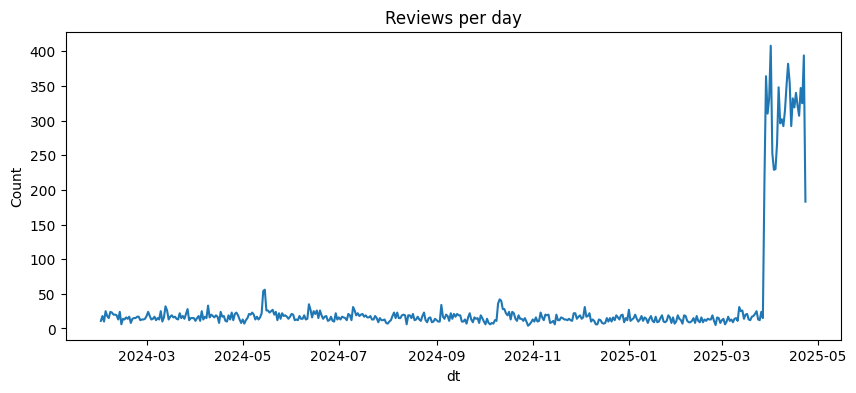

In [60]:
df_recent = df[df["dt"] >= "2024-02-01"]
df_recent.groupby(df_recent["dt"].dt.date)["id"].count().plot(figsize=(10,4), title="Reviews per day")
plt.ylabel("Count")
plt.show()

# Simple EDA plot

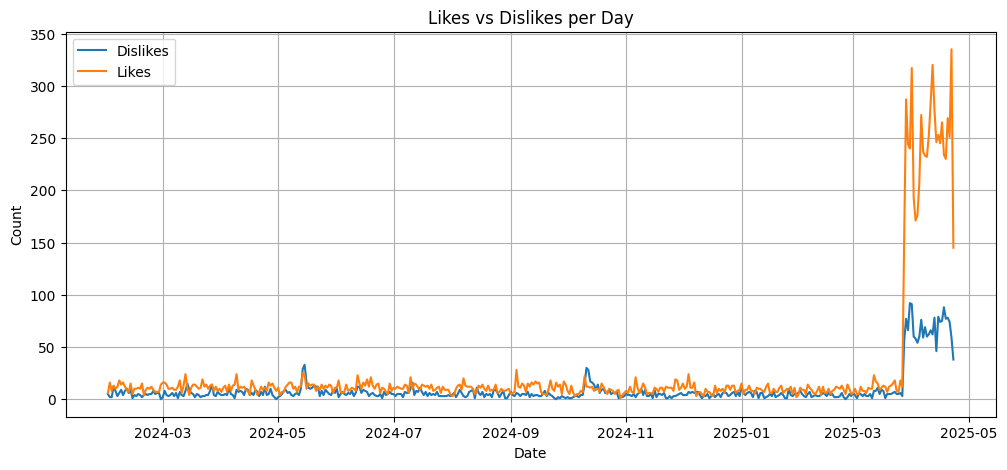

In [61]:

# Step 1: Grouping by day and label
df_recent = df[df["dt"] >= "2024-02-01"] # taking only recent relevant dates (3 months back)
daily_counts = df.groupby([df_recent["dt"].dt.date, "label"]).size().unstack(fill_value=0)

# Step 3: Rename columns for clarity
daily_counts.columns = ["Dislikes", "Likes"]  # because 0 = dislike, 1 = like

# Step 4: Plot
daily_counts.plot(kind="line", figsize=(12, 5), title="Likes vs Dislikes per Day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True)
plt.show()


## 3 Clustering – K‑Means, Agglomerative, DBSCAN

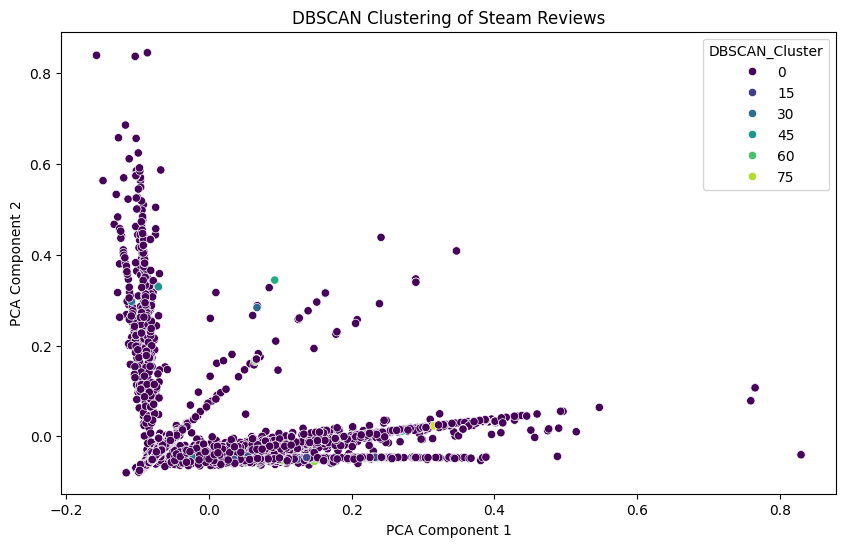

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2), stop_words='english')
X = tfidf.fit_transform(df['text'])

# Clustering with DBSCAN (cosine metric is common for text)
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
df['DBSCAN_Cluster'] = dbscan.fit_predict(X)

# Reduce dimensions for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='pca1', y='pca2', hue='DBSCAN_Cluster', data=df, palette='viridis')
plt.title('DBSCAN Clustering of Steam Reviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


## Kmeans

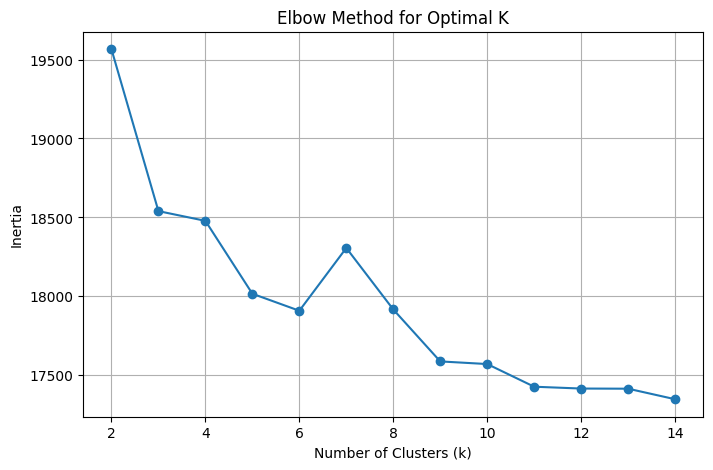

In [64]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Step 1: TF-IDF
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2), stop_words='english')
X = tfidf.fit_transform(df['text'])

# Step 2: Elbow method - compute inertia for a range of cluster counts
inertias = []
k_range = range(2, 15)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X)
    inertias.append(km.inertia_)

# Step 3: Plot elbow
plt.figure(figsize=(8,5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


## 4 Time‑Series Forecasting – ARIMA

In [ ]:

serie = df.set_index('dt')['id'].resample('D').count().rename('count')
train, test = serie.iloc[:-30], serie.iloc[-30:]

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
res   = model.fit(disp=False)
forecast = res.get_forecast(30).predicted_mean

mape = (abs(forecast - test) / test).mean()
print(f"MAPE: {mape:.2%}")

ax = train.plot(label="Train", figsize=(10,4))
test.plot(ax=ax, label="Test")
forecast.plot(ax=ax, label="Forecast")
plt.legend(); plt.show()

## 5 Explainability & Fairness – Logistic Regression + SHAP

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, stratify=df['label'])
clf = LogisticRegression(max_iter=300, n_jobs=-1)
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))
print("AUC:", roc_auc_score(y_test, clf.decision_function(X_test)))

import shap, langdetect
explainer = shap.LinearExplainer(clf, X_train, feature_perturbation='sampling')
shap_values = explainer.shap_values(X_test[:100])
shap.summary_plot(shap_values, feature_names=tfidf.get_feature_names_out())

In [ ]:

# Language bias quick check
df['lang'] = df['text'].apply(lambda t: langdetect.detect(t[:200]))
df.groupby('lang')['label'].mean().sort_values(ascending=False).head()

## 6 Hyper‑parameter Tuning & Evaluation

In [ ]:

from sklearn.model_selection import GridSearchCV
grid = {'C':[0.1,1,5], 'penalty':['l2'], 'class_weight':[None,'balanced']}
gs = GridSearchCV(clf, grid, cv=5, scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV AUC:", gs.best_score_)